Facial Expression Recognition

# Data Augmentation

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = Path("/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train")
test_path = Path("/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/test")

In [ ]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78157033.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78169005.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_77992952.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78092602.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78019469.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_79254931.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78863544.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_78992197.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_79140997.jpg',
 '/content/drive/MyDrive/ML DL WISE Project/Pic Data Set/train/fear/Training_79085920.jpg']

In [ ]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
train_image_labels[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.802, 1: 17.107595, 2: 1.7534869, 3: 1.0, 4: 1.4350942, 5: 1.4946088, 6: 2.2762105}


In [ ]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 32

resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [ ]:
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 536 ms, sys: 11 ms, total: 547 ms
Wall time: 599 ms
(32, 96, 96, 3)
(32, 7)


neutral


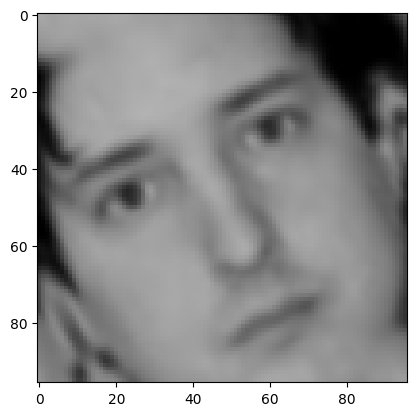

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 28.2 ms, sys: 920 µs, total: 29.1 ms
Wall time: 30.5 ms
(32, 96, 96, 3)
(32, 7)


neutral


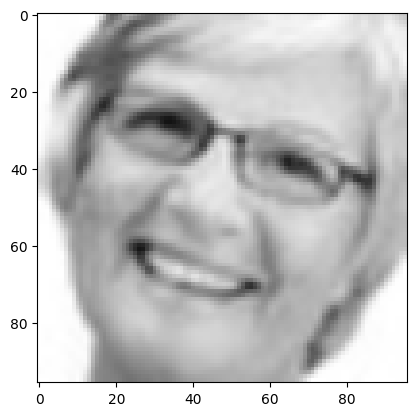

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[1].numpy()/255).reshape(96 , 96 , 3))

# Model Training

In [ ]:
from tensorflow.keras.applications import EfficientNetB6

backbone = EfficientNetB6(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

165234480/165234480 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional  (None, 3, 3, 2304)        40960143  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 41256086 (157.38 MB)
Trainable params: 4

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

Training Phase 1

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
673/673 [==============================] - 3125s 4s/step - loss: 2.8515 - accuracy: 0.3882 - precision: 0.6537 - recall: 0.1824 - val_loss: 1.3527 - val_accuracy: 0.5119 - val_precision: 0.7221 - val_recall: 0.3103
Epoch 2/12
673/673 [==============================] - 200s 297ms/step - loss: 2.3998 - accuracy: 0.4891 - precision: 0.6919 - recall: 0.2837 - val_loss: 1.2433 - val_accuracy: 0.5269 - val_precision: 0.7156 - val_recall: 0.3371
Epoch 3/12
673/673 [==============================] - 197s 292ms/step - loss: 2.2518 - accuracy: 0.5173 - precision: 0.7051 - recall: 0.3188 - val_loss: 1.2639 - val_accuracy: 0.5294 - val_precision: 0.6574 - val_recall: 0.3863
Epoch 4/12
673/673 [==============================] - 202s 300ms/step - loss: 2.1256 - accuracy: 0.5477 - precision: 0.7209 - recall: 0.3545 - val_loss: 1.1989 - val_accuracy: 0.5525 - val_precision: 0.6834 - val_recall: 0.4304
Epoch 5/12
673/673 [==============================] - 201s 299ms/step - loss: 2.0249 - acc

In [ ]:
model.layers[0].trainable = False

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional  (None, 3, 3, 2304)        40960143  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 41256086 (157.38 MB)
Trainable params: 2

Training Phase - 2

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
673/673 [==============================] - ETA: 0s - loss: 1.6091 - accuracy: 0.6405 - precision: 0.7581 - recall: 0.5131
Epoch 1: val_loss improved from inf to 1.07717, saving model to best_weights.h5
673/673 [==============================] - 215s 315ms/step - loss: 1.6091 - accuracy: 0.6405 - precision: 0.7581 - recall: 0.5131 - val_loss: 1.0772 - val_accuracy: 0.6147 - val_precision: 0.7123 - val_recall: 0.4983
Epoch 2/8
673/673 [==============================] - ETA: 0s - loss: 1.5611 - accuracy: 0.6478 - precision: 0.7567 - recall: 0.5228
Epoch 2: val_loss improved from 1.07717 to 1.05625, saving model to best_weights.h5
673/673 [==============================] - 198s 294ms/step - loss: 1.5611 - accuracy: 0.6478 - precision: 0.7567 - recall: 0.5228 - val_loss: 1.0563 - val_accuracy: 0.6170 - val_precision: 0.7243 - val_recall: 0.5011
Epoch 3/8
673/673 [==============================] - ETA: 0s - loss: 1.5375 - accuracy: 0.6501 - precision: 0.7641 - recall: 0.5320
Epoch 

# Model Testing

In [ ]:
from tensorflow.keras.applications import EfficientNetB6

backbone = EfficientNetB6(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


surprise


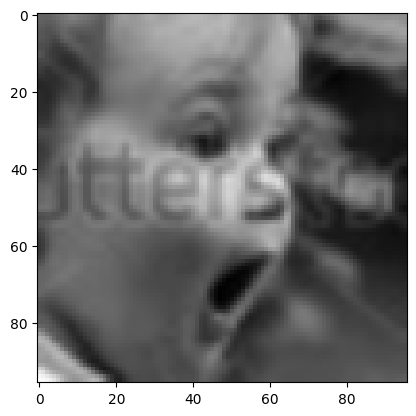

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
loss, acc, prec, rec = model.evaluate(test_dataset)

In [ ]:
print(" Testing Acc : " , acc*100)
print(" Testing Precision " , prec*100)
print(" Testing Recall " , rec*100)

 Testing Acc :  91.8701293684224
 Testing Precision  84.7474570274353
 Testing Recall  76.10016775131227


# Saving Model and Objects

In [ ]:
model.save("ExpressionRecognitionModel.h5")

In [ ]:
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")